In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import csv
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Model, load_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_probability as tfp
tfd=tfp.distributions
tfpl=tfp.layers
from tensorflow import math
from tensorflow import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def read_data(path):

    #open path to read dataset.csv
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    #assgin array to load two images and labels
    frame_0 = []
    frame_1 = []
    label = []

    for item in reader:   
    #read frames' path and labels
        frame_0_temp = item[0]
        frame_1_temp = item[1]
        label_temp = item[2]
        label_temp = float(label_temp)  
    #load frame through the frame path
        img0 = cv2.imread(frame_0_temp)
        img1 = cv2.imread(frame_1_temp)
    # use "append" to load images to array
        frame_0.append(img0)
        frame_1.append(img1)
        label.append(label_temp)
    #print('read data part: ',label)
    return frame_0, frame_1, label

def process_data(f0,f1,lab):

  #lab=keras.utils.to_categorical(lab, 1)
  f0 = np.asarray(f0)
  f1 = np.asarray(f1)
  lab = np.asarray(lab)
  #print(lab)
  return f0,f1,lab

In [3]:
training_path = '/content/drive/MyDrive/Daming Colab/Ranking/mix_train_data_set_20000.csv'
validation_path = '/content/drive/MyDrive/Daming Colab/Ranking/mix_train_data_set_10000.csv'

frame_0_train, frame_1_train, label_train = read_data(training_path)
frame_0_val, frame_1_val, label_val = read_data(validation_path)

frame_0_train, frame_1_train, label_train = process_data(frame_0_train, frame_1_train, label_train)
frame_0_val, frame_1_val, label_val = process_data(frame_0_val, frame_1_val, label_val)

print("finish loading DATA !")

finish loading DATA !


In [4]:
VGG16=tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    )

VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
x=VGG16.get_layer('fc2').output

m = layers.Dense(1)(x)   
#s = layers.Dense(1)(x) 

mean = layers.Dropout(0.01)(m)
#log_sigma = layers.Dropout(0.001)(s)

'''
stdlayer=layers.Lambda(lambda x:
                tf.math.exp (tf.math.subtract (x,0.0)) )
std=stdlayer(s)
    
samplelayer=layers.Lambda(lambda x:
                  x[0]+tf.math.multiply(x[1],tf.random.normal(shape=[1], mean=0.0, stddev=1)))
sample=samplelayer([m,std])
'''
Base=Model(inputs=VGG16.input,outputs=mean)

VGG16.trainable = False

#Base.layers[-5].trainable=True
#Base.layers[-4].trainable=True
#Base.layers[-3].trainable=True
#Base.layers[-2].trainable=True
Base.layers[-1].trainable=True

for layer in Base.layers:
    #print(layer.trainable)
    adam=keras.optimizers.Adam(0.001)

Base.summary()
#plot_model(Base, show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
def siamese():
  
    input_tensor = layers.Input(shape=(224, 224, 3))
    #base_model = Base()

    input_frame_0 = layers.Input(shape=(224, 224, 3))
    input_frame_1 = layers.Input(shape=(224, 224, 3))
    
    s1 = Base(input_frame_0)
    s2 = Base(input_frame_1)                  

    diff = keras.layers.Subtract()([s1,s2])  

    score = layers.Dense(1, activation='sigmoid')(diff)

    siamese_model = Model(inputs=[input_frame_0, input_frame_1], outputs=score)

    return siamese_model

siamese_model=siamese()
siamese_model.summary()
#plot_model(siamese_model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            134264641   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           model[0][0]                

In [7]:
siamese_model.compile(keras.optimizers.SGD(learning_rate=2e-5),
                      loss=keras.losses.binary_crossentropy,
                      metrics=['accuracy'])

history=siamese_model.fit([frame_0_train, frame_1_train], label_train, 
                          epochs=10, batch_size=20, 
                          validation_data=([frame_0_val, frame_1_val], label_val), 
                          shuffle=True,
                          verbose=1)

Epoch 1/10
1000/1000 [==============================] - 156s 150ms/step - loss: 0.6855 - accuracy: 0.5337 - val_loss: 0.6700 - val_accuracy: 0.5885
Epoch 2/10
1000/1000 [==============================] - 148s 148ms/step - loss: 0.6544 - accuracy: 0.6477 - val_loss: 0.6385 - val_accuracy: 0.7045
Epoch 3/10
1000/1000 [==============================] - 148s 148ms/step - loss: 0.6207 - accuracy: 0.7648 - val_loss: 0.6026 - val_accuracy: 0.8074
Epoch 4/10
1000/1000 [==============================] - 148s 148ms/step - loss: 0.5817 - accuracy: 0.8274 - val_loss: 0.5613 - val_accuracy: 0.8422
Epoch 5/10
1000/1000 [==============================] - 147s 148ms/step - loss: 0.5385 - accuracy: 0.8544 - val_loss: 0.5167 - val_accuracy: 0.8611
Epoch 6/10
1000/1000 [==============================] - 147s 148ms/step - loss: 0.4934 - accuracy: 0.8676 - val_loss: 0.4725 - val_accuracy: 0.8694
Epoch 7/10
1000/1000 [==============================] - 147s 147ms/step - loss: 0.4517 - accuracy: 0.8762 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


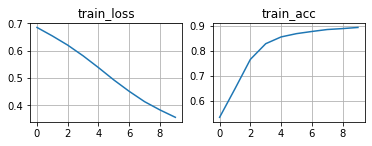

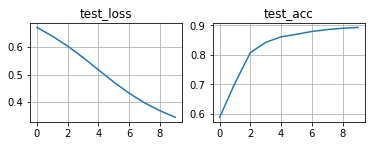

In [8]:
print(history.history.keys())
plt.subplot(221)
plt.plot(history.history["loss"])
plt.grid()
plt.title("train_loss")

plt.subplot(222)
plt.plot(history.history["accuracy"])
plt.grid()

plt.title("train_acc")
plt.show()

plt.subplot(221)
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("test_loss")

plt.subplot(222)
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("test_acc") 
plt.show()

In [10]:
Base.save('/content/drive/MyDrive/Daming Colab/Ranking/Model/DTR/_Drankingnet_VGG4097_dp10eMD.h5')